# Conservative Methods

We solve the Burgers equation (and the advection equation) using the KT2 (second-order Kurganov-Tadmor), MP5 (5th-order monotonicity preserving), and WENOZ methods.

[Click here to download the necessary auxiliary file](/weave/lab06/shocks_utils.jl).

In [ ]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations
using Plots
using Printf

include("shocks_utils.jl")

Here, we decide which equation to solve. This will be used later when choosing the `Flux_x!` function.

In [12]:
#problem = :advection
problem = :burgers

:burgers

We will use the Kurganov-Tadmor method (which is second order and semidiscrete), WENO-Z, and MP5

We define the maximum propagation speed. This is necessary to adjust the method's dissipation, as well as to ensure stability. What matters is to have a lower bound for the maximum wave propagation speed at any point.

In [28]:
#Velocidad máxima de propagación

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U) 
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

burgersspeed (generic function with 1 method)

Here we define the `Flux_x!` function. Recall that we are solving problems of the form

$$
u_t = F(u)_x
$$

In [29]:
#Fluxes
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

burgers! (generic function with 1 method)

Now we finally begin to construct the problem. First, we define the spatial and temporal interval, along with the vector where we will store the solution. We also choose some parameters for the problem.

In [33]:
# --- Spatial Discretization ---
N = 100          # Number of grid points
N_FIELDS = 1     # Number of solution fields (e.g., 1 for a scalar equation)

domain_start = 0.0    # Start of the spatial domain
domain_stop = 2.0 * pi # End of the spatial domain

# Create the spatial grid: N points, excluding the endpoint (domain_stop).
x = range(domain_start, stop=domain_stop, length=N + 1)[1:end-1]
dx = Float64(step(x)) # Spatial step size (Δx)
 h = 1.0 / dx         # Inverse of dx
 
# --- Initial Condition ---
# Initialize the solution array 'u' and a temporary array 'du' (e.g., for Runge-Kutta stages or storing residuals)
u = Array{Float64}(undef, N, N_FIELDS)
du = similar(u) # Creates an array with the same dimensions and type as 'u', uninitialized.

# Set the initial condition: u(x,0) = 0.5 + sin(x)
# The @. macro broadcasts the operations element-wise.
@. u[:, 1] = 0.5 + sin(x)

# --- Temporal Discretization ---
T = 4.0          # Total integration time
tspan = (0.0, T) # Tuple defining the time interval [initial_time, final_time]

# CFL condition: CFL = speed * dt / dx.
# Here, we set the CFL number and calculate dt based on dx.
# The effective 'speed' is implicitly 1 in this dt calculation,
# or the numerical scheme itself handles the actual wave speeds.
CFL = 0.1
dt = dx * CFL    # Time step (Δt)

# --- Problem-Specific Parameters ---
# 'eqpars' will hold parameters specific to the chosen PDE.
# This variable 'problem' (a Symbol, e.g., :advection or :burgers)
# would need to be defined elsewhere in your script.

if problem == :advection
    # For an advection equation like u_t + a * u_x = 0,
    # 'eqpars' could be the advection speed 'a'.
    eqpars = 1.0 # Example: advection speed
elseif problem == :burgers
    # For Burgers' equation u_t + (0.5 * u^2)_x = 0,
    # 'eqpars' might not be needed if the non-linearity is handled directly in Flux_x!,
    # or it could be a coefficient if the equation was u_t + (coeff * u^2)_x = 0.
    # 'false' is an unconventional parameter; it might signify that no external
    # scalar parameter is needed for the Burgers' flux function, or it's a boolean flag
    # for some internal logic within the flux calculation.
    eqpars = false # Placeholder or specific flag for Burgers'
end

false

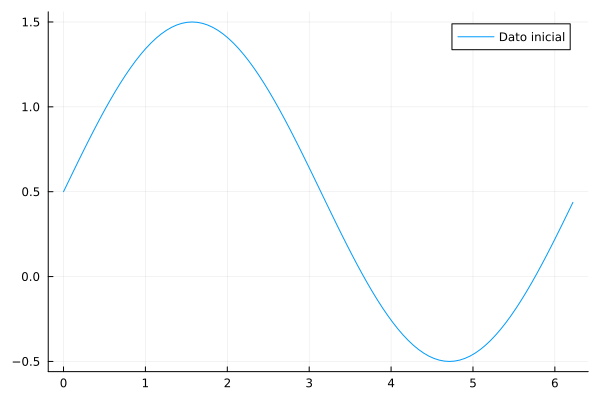

In [34]:
#Initial data
plot(x, u[:,1], label = "Dato inicial")

Here we choose the spatial resolution method and prepare the tuple `par` for later integration. Several of these functions are defined in `choques_utils.jl`.

In [35]:
# --- List of methods to compare ---

# Kurganov-Tadmor (KT2)
# θ: This value must be between 1.0 and 2.0.
#    The closer it is to 2.0, the lower the dissipation.
#    For systems of equations, it's better for it to be closer to 1.0 to avoid oscillations.
θ = 2.0
auxvectorsKT = createKTauxvectors(N_FIELDS)
parKT = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectorsKT)

# WENOZ
auxvectorsWENOZ = createWENOZvectors(N_FIELDS)
parWENOZ = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectorsWENOZ)

# MP5 (Monotonicity Preserving 5th order)
auxvectorsMP5 = createMP5auxvectors(N_FIELDS)
parMP5 = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectorsMP5)


(false, 15.915494309189533, 100, 1, Main.burgers!, Main.burgersspeed, ([0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]))

The solution is a matrix of size `N x N_Fields`. For scalar problems, this essentially means it's a vector with a single column, but you can try it with systems of equations and it will work the same.
Remember that for convergence analysis, it is convenient to use initial data that is smooth and piecewise polynomial.

Now we are ready to define the problems, choose integrators, and set their behavior. Here it is important to choose a stable integrator, i.e., one whose stability region includes part of the imaginary axis, and preferably one that is TVD (Total Variation Diminishing). In our case, we will choose the Runge-Kutta integrator `SSPRK33`, which is third-order in time and is TVD.

In [36]:
probKT = ODEProblem(KT!,u,tspan,parKT);
probWENOZ = ODEProblem(wenoz!,u,tspan,parWENOZ);
probMP5 = ODEProblem(mp5!,u,tspan,parMP5);

In [37]:
solKT = solve(probKT,SSPRK33(),dt=dt, saveat = T/100);

In [38]:
solWENOZ = solve(probWENOZ,SSPRK33(),dt=dt, saveat = T/100);

In [39]:
solMP5 = solve(probMP5,SSPRK33(),dt=dt, saveat = T/100);

Once we have the solution, we can analyze it. Here we show how to plot it.

┌ Info: Saved animation to /home/pablo/Documentos/SAFIR/pde/2024/Numericos/Tarea_4/burgers_sin.gif
└ @ Plots /home/pablo/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/pablo/Documentos/SAFIR/pde/2024/Numericos/Tarea_4/burgers_sin.gif")
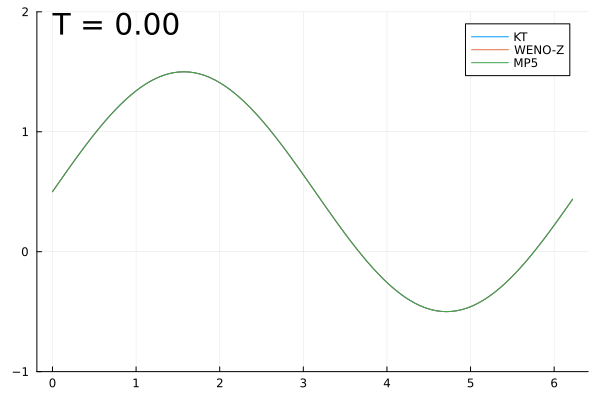

In [40]:

anim = @animate for t in solKT.t
    plt = plot(x, solKT(t), ylims = (-1.0,2.0), label = "KT")
    plot!(plt, x, solWENOZ(t), ylims = (-1.0,2.0), label = "WENO-Z")
    plot!(plt, x, solMP5(t), ylims = (-1.0,2.0), label = "MP5")
    annotate!(plt, 0.0, 1.9, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgers_sin.gif", fps = 30)

### Help for Convergence Analysis in KT

For the MP5 and WENOZ methods, you can analyze convergence using the $L_1$ norm. For the Kurganov-Tadmor method, you will need to use the **$Lip'$** norm. We will provide the implementation of this norm and how to use it to calculate the factor $Q$.

In [41]:
function Lipprime(u, dx)
    pr = zeros(size(u)[1])
    for i in 2:size(u)[1]
        pr[i] = pr[i-1] + (u[i]+u[i-1])*dx
    end
    return sum(abs.(pr))*dx
end
function QKT(t, sol1, sol2, sol4, dx1, dx2)
    n1 = Lipprime(sol1(t)[:,1]-sol2(t)[1:2:end,1], dx1)
    n2 = Lipprime(sol2(t)[:,1]-sol4(t)[1:2:end,1], dx2)
    return log2(n1/n2)
end

QKT (generic function with 1 method)